In [1]:
import numpy as np
import math
import scipy.io as sio
from tqdm import tqdm
import matplotlib.pyplot as plt

### Load Data

In [2]:
tmp = sio.loadmat("mnist_all.mat")
train0= tmp['train0']
train1= tmp['train1']
test0= tmp['test0']
test1= tmp['test1']

xtrain= np.vstack((train0, train1))
ytrain=np.hstack((np.zeros(train0.shape[0]), np.ones(train1.shape[0])))
ytrain= np.asmatrix(ytrain)
xtrain= xtrain.T
xtest= np.vstack((test0, test1))
ytest= np.hstack((np.zeros(test0.shape[0]), np.ones(test1.shape[0])))
ytest= np.asmatrix(ytest)
xtest= xtest.T

In [3]:
train= np.vstack((xtrain, ytrain))
train= train.T
np.random.shuffle(train)
train=train.T
print(train.shape)
print(train)
xtrain= np.split(train, [-1])[0]
ytrain=np.split(train, [-1])[1]
print(xtrain.shape)
print(ytrain.shape)

(785, 12665)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 1.]]
(784, 12665)
(1, 12665)


In [4]:
test= np.vstack((xtest, ytest))
test= test.T
np.random.shuffle(test)
test=test.T
print(test.shape)
print(test)
xtest= np.split(test, [-1])[0]
ytest=np.split(test, [-1])[1]
print(xtest.shape)
print(ytest.shape)

(785, 2115)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]
(784, 2115)
(1, 2115)


### Define Functions for neural network

In [5]:
# initialize weights
def initialize(num_neur, d):
    H= num_neur
    
    num_layers= d+2
    
    layersize= [0]*(num_layers+1)
    layersize[0]= 784
    
    params= {}
    
    for l in range(1, num_layers):
        if l== num_layers-1:
            layersize[l] =1
        else:
            layersize[l]= 50
            
        
        params['W'+str(l)]= np.random.normal(0, 
                            math.sqrt(1/layersize[l-1]), 
                            (layersize[l], layersize[l-1]))

        params['b'+str(l)]= np.zeros((layersize[l], 1))
        
    return params



In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


In [7]:
def sig_deriv(x):
    S= sigmoid(x)
    dS= np.multiply(S,(1-S))
    
    return dS
    

Forward Propagation

In [8]:
def forward(x, params, num_layers):
    
    cache= {}

    h= x
    
    for l in range(1, num_layers):
        
        h_prev= h
        w= params['W'+str(l)]
        b= params['b'+str(l)]
        z= np.dot(w, h_prev)+b
        h= sigmoid(z)
        
        cache['Z'+str(l)]= z
        if l>1:
            cache['H'+str(l-1)]= h
        else:
            cache['H'+str(l-1)]=x
    f= h
    
    return f, cache
    

In [9]:
def loss_func(f, y):
    m= y.shape[1]
    
    log= np.multiply(np.log(f), y)+np.multiply((1-y), np.log(1-f))
    
    loss= -np.sum(log)/m
        
    return np.squeeze(loss)

Backwards propagation

In [10]:
def backwards(f, y, params, cache, num_layers):
    grade= {}
    
    m= f.shape[1]
    y= y.reshape(f.shape)
    
    df= -(np.divide(y, f)-np.divide(1-y, 1-f))
    dH_prev= df
    
    for i in reversed(range(1, num_layers)):
        dH_cur= dH_prev
        
        w_cur= params['W'+str(i)]
        z_cur= cache['Z'+str(i)]
        h_prev= cache['H'+str(i-1)]
        
        dz, dw_cur, db_cur= reverse(dH_cur, z_cur, h_prev, w_cur)
         
        dH_prev= np.dot(w_cur.T, dz)
        
        grade["dW"+str(i)]= dw_cur
        grade["db"+str(i)]= db_cur
        
        
    return grade
    
    

In [15]:
def reverse(dH, z, h_prev, w):
    dZ= np.multiply(dH, sig_deriv(z))
    m= h_prev.shape[1]
    
    dw= np.dot(dZ, h_prev.T)/m
    db= np.sum(dZ, axis=1)/m
    dH_prev= np.dot(w.T, dZ)
    
    return dZ, dw, db

Update Parameters

In [16]:
def update(params, grade, a, num_layers):
    
    for i in range(1, num_layers):
        params["W"+str(i)]= params["W"+str(i)]-a*grade["dW"+str(i)]
        params["b"+str(i)]= params["b"+str(i)]-a*grade["db"+str(i)]
        
    return params

### Run network

In [17]:
def NNtrain(x, y, train, num_neur, d, learnrate= 0.0075, num_iter= 10000):
    loss=[]
    
    params = initialize(num_neur, d)
    num_layers= d+2
    
    for i in range(num_iter):
        
        batch= train[:,[np.random.choice(train.shape[1], 100, replace=False)]]
        batch= np.squeeze(batch)
        xnew= np.split(train, [-1])[0]
        ynew=np.split(train, [-1])[1]
        
        f, cache= forward(xnew, params, num_layers)
        
        lossoniter= loss_func(f, ynew)
        
        grade = backwards(f, ynew, params, cache, num_layers)
        params =update(params, grade, learnrate, num_layers)
        
        if i%500==0:
            print("Loss after iteration %i: %f" %(i,lossoniter))
            
        loss.append(lossoniter)
        
    f, cache= forward(x, params, num_layers)
    lossfinal= loss_func(f, y)
    print("final loss= "+ str(lossfinal))
    
    plt.plot(np.squeeze(loss))
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.show()
    
    return params, loss
    

Loss after iteration 0: 0.682802
Loss after iteration 500: 0.473610
Loss after iteration 1000: 0.461222
Loss after iteration 1500: 0.445484
Loss after iteration 2000: 0.413127
Loss after iteration 2500: 0.379691
Loss after iteration 3000: 0.346468
Loss after iteration 3500: 0.303171
Loss after iteration 4000: 0.264147
Loss after iteration 4500: 0.234374
Loss after iteration 5000: 0.203936
Loss after iteration 5500: 0.178610
Loss after iteration 6000: 0.155054
Loss after iteration 6500: 0.135874
Loss after iteration 7000: 0.119463
Loss after iteration 7500: 0.105321
Loss after iteration 8000: 0.093116
Loss after iteration 8500: 0.082174
Loss after iteration 9000: 0.073516
Loss after iteration 9500: 0.066023
final loss= 0.05936027064030787


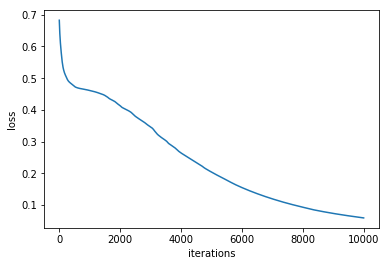

In [18]:
trainedparams, loss= NNtrain(xtrain, ytrain, train, 50, 2)

In [19]:
# Calculate Loss for test set
f, cache= forward(xtest, trainedparams, 4)
testloss= loss_func(f, ytest)
print(testloss)

0.05785867890765255


### Part c: 
How does dW1 change as d gets bigger?

In [21]:
dw1= []
for i in range(4):
    params= initialize(50, i+1)
    f, cache= forward(xtrain, params, i+3)
    grade = backwards(f, ytrain, params, cache, i+3)
    dw1.append(np.linalg.norm(grade["dW"+str(1)]))
    
print(dw1)

# as you can see, the gradient is clearly decreasing
# as the number of hidden layers increases

[3.2930179752687936, 0.6233535900346424, 0.1491313139600949, 0.03316026205293577]
